In [284]:
import pandas as pd
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
import xgboost as xgb
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold
from sklearn.metrics import explained_variance_score,mean_absolute_error, mean_squared_error,mean_absolute_percentage_error, r2_score
from sklearn.model_selection import TimeSeriesSplit
from hyperopt import fmin, tpe, hp, STATUS_OK
from statsmodels.tsa.seasonal import seasonal_decompose

pd.set_option('display.max_columns', None)


In [285]:
historical_data = pd.read_csv('02 Sales_Expense_InputFile.csv')
historical_data

,ACCOUNT_ID,Type,COUNTRY,PRODUCT,MONTH,UNIT_SALES (in Million $),Per Unit Expense,TOTAL_EXPENSE (in Million $),SALESFORCE_EXPENSE (in Million $),DIGITAL_EXPENSE (in Million $)
0,376321,Medium,COUNTRY 1,Drug_2,8/1/10,61.231684,5.827554,10.507271,6.100165,3.463933
1,376321,Medium,COUNTRY 1,Drug_2,9/1/10,47.286854,4.277412,11.055016,6.037500,3.830352
2,376321,Medium,COUNTRY 1,Drug_2,10/1/10,29.143185,1.919907,15.179476,8.310196,5.591070
3,376321,Medium,COUNTRY 1,Drug_2,11/1/10,74.909233,5.073759,14.764051,8.348021,5.254492
4,376321,Medium,COUNTRY 1,Drug_2,12/1/10,37.441141,2.455262,15.249345,9.054047,5.889636
...,...,...,...,...,...,...,...,...,...,...
29536,6203,High,COUNTRY 5,Drug_3,6/1/18,12.792047,2.271011,5.632755,2.420276,1.863798
29537,6203,High,COUNTRY 5,Drug_3,7/1/18,12.601030,3.777057,3.336204,1.445817,0.588727
29538,6203,High,COUNTRY 5,Drug_3,8/1/18,5.514425,1.601728,3.442797,1.130916,0.586088
29539,6203,High,COUNTRY 5,Drug_3,9/1/18,5.369521,2.667149,2.013206,0.880773,0.014755


In [286]:
account_potential = pd.read_csv('03 Account_Potential_Data.csv')
account_potential.columns  = account_potential.columns.str.capitalize()
account_potential['Account_id'] = account_potential['Account_id'].apply(lambda x: '{0:0>8}'.format(x))   ## Added leading zeros to account ids which were shorter than 8 in length
account_potential['Account_id'] = account_potential['Account_id'].astype(str)

In [181]:
print ('Row Count: {}'.format(historical_data.shape[0]))
print ('Column Count: {}'.format(historical_data.shape[1]))
display(historical_data.isna().sum())

Row Count: 29541
Column Count: 10


ACCOUNT_ID                           0
Type                                 0
COUNTRY                              0
PRODUCT                              0
MONTH                                0
UNIT_SALES (in Million $)            0
Per Unit Expense                     0
TOTAL_EXPENSE (in Million $)         0
SALESFORCE_EXPENSE (in Million $)    0
DIGITAL_EXPENSE (in Million $)       0
dtype: int64

In [182]:
missing_values_columns = historical_data.isnull().sum().sort_values(ascending=False)
display(pd.DataFrame(missing_values_columns[missing_values_columns[missing_values_columns > 0].index]))

,0


In [183]:
historical_data.dtypes

ACCOUNT_ID                             int64
Type                                  object
COUNTRY                               object
PRODUCT                               object
MONTH                                 object
UNIT_SALES (in Million $)            float64
Per Unit Expense                     float64
TOTAL_EXPENSE (in Million $)         float64
SALESFORCE_EXPENSE (in Million $)    float64
DIGITAL_EXPENSE (in Million $)       float64
dtype: object

In [287]:
#doing some initial formatting to the columns

# changing column names to lower case
historical_data.columns = historical_data.columns.str.capitalize()
## Added leading zeros to account ids which were shorter than 8 in length
historical_data['Account_id'] = historical_data['Account_id'].apply(lambda x: '{0:0>8}'.format(x))
# converting date column into datetime format
historical_data['Month'] = pd.to_datetime(historical_data['Month'])
# renaming the month column to week
historical_data.rename(columns = {'Month':'Week'}, inplace = True)
historical_data['Account_id'].astype(str)
# extracting year and month from date
historical_data['Year'] = historical_data['Week'].dt.year
historical_data['Month'] = historical_data['Week'].dt.month
display(historical_data.head(5))

,Account_id,Type,Country,Product,Week,Unit_sales (in million $),Per unit expense,Total_expense (in million $),Salesforce_expense (in million $),Digital_expense (in million $),Year,Month
0,00376321,Medium,COUNTRY 1,Drug_2,2010-08-01,61.231684,5.827554,10.507271,6.100165,3.463933,2010,8
1,00376321,Medium,COUNTRY 1,Drug_2,2010-09-01,47.286854,4.277412,11.055016,6.037500,3.830352,2010,9
2,00376321,Medium,COUNTRY 1,Drug_2,2010-10-01,29.143185,1.919907,15.179476,8.310196,5.591070,2010,10
3,00376321,Medium,COUNTRY 1,Drug_2,2010-11-01,74.909233,5.073759,14.764051,8.348021,5.254492,2010,11
4,00376321,Medium,COUNTRY 1,Drug_2,2010-12-01,37.441141,2.455262,15.249345,9.054047,5.889636,2010,12


**FEATURE ENGINEERING**

Generating new time features from the existing:  

In [288]:
historical_data['weekofyear'] = historical_data['Week'].dt.weekofyear
historical_data['quarter'] = historical_data['Week'].dt.quarter
historical_data['is_month_start'] = historical_data['Week'].dt.is_month_start
historical_data['is_month_end'] =historical_data['Week'].dt.is_month_end
historical_data['is_quarter_start'] = historical_data['Week'].dt.is_quarter_start
historical_data['is_quarter_end'] = historical_data['Week'].dt.is_quarter_end
historical_data['is_year_start'] = historical_data['Week'].dt.is_year_start
historical_data['is_year_end'] = historical_data['Week'].dt.is_year_end

<ipython-input-288-6078081c494c>:1: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated. Please use Series.dt.isocalendar().week instead.
  historical_data['weekofyear'] = historical_data['Week'].dt.weekofyear


In [289]:
#Changing boolean to 0 and 1

historical_data['is_month_start'] = historical_data['is_month_start'].replace({True: 1, False: 0})
historical_data['is_month_end'] = historical_data['is_month_end'].replace({True: 1, False: 0})
historical_data['is_quarter_start'] = historical_data['is_quarter_start'].replace({True: 1, False: 0})
historical_data['is_quarter_end'] = historical_data['is_quarter_end'].replace({True: 1, False: 0})
historical_data['is_year_start'] = historical_data['is_year_start'].replace({True: 1, False: 0})
historical_data['is_year_end'] = historical_data['is_year_end'].replace({True: 1, False: 0})

In [290]:
#Reading the test data

test_data = pd.read_csv('final_test_data.csv')
test_data.columns = test_data.columns.str.capitalize()
test_data['Account_id'] = test_data['Account_id'].apply(lambda x: '{0:0>8}'.format(x))   ## Added leading zeros to account ids which were shorter than 8 in length
test_data['Account_id'] = test_data['Account_id'].astype(str)

In [291]:
#Generating new features for test data

test_data['Week'] = pd.to_datetime(dict(year=test_data.Year, month=test_data.Month, day='01'))
test_data['weekofyear'] = test_data['Week'].dt.weekofyear
test_data['quarter'] = test_data['Week'].dt.quarter
test_data['is_month_start'] = test_data['Week'].dt.is_month_start
test_data['is_month_end'] =test_data['Week'].dt.is_month_end
test_data['is_quarter_start'] = test_data['Week'].dt.is_quarter_start
test_data['is_quarter_end'] = test_data['Week'].dt.is_quarter_end
test_data['is_year_start'] = test_data['Week'].dt.is_year_start
test_data['is_year_end'] = test_data['Week'].dt.is_year_end

<ipython-input-291-52d385527ab1>:4: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated. Please use Series.dt.isocalendar().week instead.
  test_data['weekofyear'] = test_data['Week'].dt.weekofyear


In [292]:
#Changing the boolean values to 0 and 1

test_data['is_month_start'] = test_data['is_month_start'].replace({True: 1, False: 0})
test_data['is_month_end'] = test_data['is_month_end'].replace({True: 1, False: 0})
test_data['is_quarter_start'] = test_data['is_quarter_start'].replace({True: 1, False: 0})
test_data['is_quarter_end'] = test_data['is_quarter_end'].replace({True: 1, False: 0})
test_data['is_year_start'] = test_data['is_year_start'].replace({True: 1, False: 0})
test_data['is_year_end'] = test_data['is_year_end'].replace({True: 1, False: 0})

In [293]:
#Merging account potentials with test data
test_data = pd.merge(test_data,account_potential, on ='Account_id',how='left')
test_data.rename(columns = {'Account_potential':'Type'}, inplace = True)

**POPULATING THE EXPENSES FOR TEST DATA**

In [294]:
#collecting historical data of 2018 (Jan - Oct)

historical_data_2018 =  historical_data[historical_data['Year']==2018].reset_index(drop=True)

In [295]:
#Adding two new columns - salesforce ratio(ratio of salesforce expense to total expense) and
#no. of units(obtained by dividing total expense with per unit expense)

historical_data_2018['Salesforce_ratio'] = historical_data_2018['Salesforce_expense (in million $)']/historical_data_2018['Total_expense (in million $)']
historical_data_2018['No. of Units'] = historical_data_2018['Total_expense (in million $)']/historical_data_2018['Per unit expense']

1. **To calculate the expenses in the future months, deployed the following:**


*   Taking the mean of Total Expenses for the year 2018 (Jan-Oct)
*   Taking the value of Expenses for the same month last year.
*   Averaging the two to get the potential expenses made by the company in the particular future month.

Sample calculation for Total Expenses of November 2018 (whose sales are to be predicted)-

*Average of (Mean Total Expenses from January to October 2018 + Expenses for November 2017)*

Note: This strategy is deployed to train the model thrice(to get the upper and lower values of predicted sales).

 - For the lower value, expenses are :

*Average of (Mean - Standard Deviation of Total Expenses from January to October 2018 + Expenses for November 2017)*

 - For the upper value, expenses are:

*Average of (Mean + Standard Deviation of Total Expenses from January to October 2018 + Expenses for November 2017)*

2. **To calculate the number of units in the future months, adopted the same strategy.**

*Average of (Mean Number of Units from January to October 2018 + Number of Units for November 2017)*

Number of Units are calculated from - Total Expenses/Per Unit Expense

3. **To get the salesforce ratio - to compute the split of salesforce and digital expenses for the future months:**

Have taken the median salesforce ratio for the year of 2018 (Jan-Oct)


In [296]:
#CASE1 (Normal value)

#DO NOT RUN IF YOU'RE RUNNING CASE 2 OR 3
df1 = historical_data_2018.groupby(by = ['Account_id','Product','Type']).agg({"Total_expense (in million $)":np.nanmean,"Salesforce_ratio":np.nanmedian,'No. of Units':np.nanmean}).reset_index()

In [193]:
#CASE2 (use for the 2nd run of the model, lower limit)

#DO NOT RUN IF YOU'RE RUNNING CASE 1 OR 3
df1= pd.merge(historical_data_2018.groupby(by = ['Account_id','Product','Type']).agg({"Total_expense (in million $)":np.nanmean,"Salesforce_ratio":np.nanmedian,'No. of Units':np.nanmean}).reset_index(),
               historical_data_2018.groupby(by = ['Account_id','Product','Type']).agg({"Total_expense (in million $)":np.nanstd}).reset_index(), on=['Account_id','Product','Type'],how='inner')
df1['Total_expense (in million $)'] = df1['Total_expense (in million $)_x']-df1['Total_expense (in million $)_y']
df1.drop(columns = {'Total_expense (in million $)_x','Total_expense (in million $)_y'},inplace = True)


In [226]:
#CASE3 (use for the 3rd run of the model, upper limit)

# DO NOT RUN IF YOU'RE RUNNING CASE 1 OR 2
df1= pd.merge(historical_data_2018.groupby(by = ['Account_id','Product','Type']).agg({"Total_expense (in million $)":np.nanmean,"Salesforce_ratio":np.nanmedian,'No. of Units':np.nanmean}).reset_index(),
               historical_data_2018.groupby(by = ['Account_id','Product','Type']).agg({"Total_expense (in million $)":np.nanstd}).reset_index(), on=['Account_id','Product','Type'],how='inner')
df1['Total_expense (in million $)'] = df1['Total_expense (in million $)_x']+ df1['Total_expense (in million $)_y']
df1.drop(columns = {'Total_expense (in million $)_x','Total_expense (in million $)_y'},inplace = True)


In [297]:
#Progress for all Models

#Taking data for year 2017 monthly and calculating monthly units
historical_data_2017 = historical_data[historical_data['Year']==2017].reset_index(drop=True)
historical_data_2017['Monthly_units'] = historical_data_2017['Total_expense (in million $)']/historical_data_2017['Per unit expense']
#historical_data_2017.columns
historical_data_2017 = historical_data_2017[['Account_id','Product','Type','Week','Total_expense (in million $)', 'Monthly_units']]

In [298]:
#Merging with the test data to get month wise data

df1.rename(columns= {'Total_expense (in million $)':'Median_Expense_2018'},inplace =True)
df2  = pd.merge(test_data, df1, on = ['Account_id', 'Product','Type'], how = 'left')
#df2 = df2[['Account_id', 'Country', 'Type','Product', ,'Year','Median_Expense_2018', 'Salesforce_ratio']]
#df2.drop_duplicates(inplace= True)
df2

,Account_id,Country,Product,Year,Month,Week,weekofyear,quarter,is_month_start,is_month_end,is_quarter_start,is_quarter_end,is_year_start,is_year_end,Type,Median_Expense_2018,Salesforce_ratio,No. of Units
0,00376321,COUNTRY 1,Drug_1,2018,11,2018-11-01,44,4,1,0,0,0,0,0,Medium,5.829264,0.507927,1.928402
1,02097539,COUNTRY 1,Drug_1,2018,11,2018-11-01,44,4,1,0,0,0,0,0,Low,14.173544,0.561829,4.372305
2,00004613,COUNTRY 1,Drug_1,2018,11,2018-11-01,44,4,1,0,0,0,0,0,High,11.724786,0.568324,4.100239
3,00541958,COUNTRY 1,Drug_1,2018,11,2018-11-01,44,4,1,0,0,0,0,0,High,12.083807,0.548351,3.679038
4,00609418,COUNTRY 1,Drug_1,2018,11,2018-11-01,44,4,1,0,0,0,0,0,Medium,11.378946,0.534661,3.418051
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2245,00558644,COUNTRY 5,Drug_2,2019,7,2019-07-01,27,3,1,0,1,0,0,0,Medium,27.584363,0.578764,8.161650
2246,00582457,COUNTRY 5,Drug_2,2019,7,2019-07-01,27,3,1,0,1,0,0,0,Medium,9.075602,0.561809,2.753888
2247,00343610,COUNTRY 5,Drug_2,2019,7,2019-07-01,27,3,1,0,1,0,0,0,Low,27.164524,0.577958,8.634448
2248,00424763,COUNTRY 5,Drug_2,2019,7,2019-07-01,27,3,1,0,1,0,0,0,High,32.582271,0.581702,10.654981


In [299]:
#merging the 2017 data with the obtained test data

final_data  = pd.merge(df2, historical_data_2017, on = ['Account_id', 'Type','Product', 'Week'], how = 'left')
final_data

,Account_id,Country,Product,Year,Month,Week,weekofyear,quarter,is_month_start,is_month_end,is_quarter_start,is_quarter_end,is_year_start,is_year_end,Type,Median_Expense_2018,Salesforce_ratio,No. of Units,Total_expense (in million $),Monthly_units
0,00376321,COUNTRY 1,Drug_1,2018,11,2018-11-01,44,4,1,0,0,0,0,0,Medium,5.829264,0.507927,1.928402,NaN,NaN
1,02097539,COUNTRY 1,Drug_1,2018,11,2018-11-01,44,4,1,0,0,0,0,0,Low,14.173544,0.561829,4.372305,NaN,NaN
2,00004613,COUNTRY 1,Drug_1,2018,11,2018-11-01,44,4,1,0,0,0,0,0,High,11.724786,0.568324,4.100239,NaN,NaN
3,00541958,COUNTRY 1,Drug_1,2018,11,2018-11-01,44,4,1,0,0,0,0,0,High,12.083807,0.548351,3.679038,NaN,NaN
4,00609418,COUNTRY 1,Drug_1,2018,11,2018-11-01,44,4,1,0,0,0,0,0,Medium,11.378946,0.534661,3.418051,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2245,00558644,COUNTRY 5,Drug_2,2019,7,2019-07-01,27,3,1,0,1,0,0,0,Medium,27.584363,0.578764,8.161650,NaN,NaN
2246,00582457,COUNTRY 5,Drug_2,2019,7,2019-07-01,27,3,1,0,1,0,0,0,Medium,9.075602,0.561809,2.753888,NaN,NaN
2247,00343610,COUNTRY 5,Drug_2,2019,7,2019-07-01,27,3,1,0,1,0,0,0,Low,27.164524,0.577958,8.634448,NaN,NaN
2248,00424763,COUNTRY 5,Drug_2,2019,7,2019-07-01,27,3,1,0,1,0,0,0,High,32.582271,0.581702,10.654981,NaN,NaN


In [ ]:
#IGNORE - FOR TEST PURPOSES TO VALIDATE THE ACCURACY OF APPROACH

# import numpy as np
# #last_error=0
# for month in range(1,9):
#     print(month)
#     last_error=0
#     df1=pd.DataFrame()
#     df1 = historical_data_2018[historical_data_2018[]<=month].groupby(by = ['Account_id','Product','Type']).agg({"Total_expense (in million $)":np.nanmedian,"Salesforce_ratio":np.nanmedian,'No. of Units':np.nanmedian}).reset_index()
#     df1.rename(columns= {'Total_expense (in million $)':'Median_Expense_2018'},inplace =True)
#     #display(df1)
#     test_data['Account_id']= test_data['Account_id'].astype(str)
#     test_data['Product']= test_data['Product'].astype(str)
#     test_data['Type']= test_data['Type'].astype(str)
#     df2  = pd.merge(test_data, df1, on = ['Account_id', 'Product','Type'], how = 'left')
#     final_data  = pd.merge(df2, historical_data_2017, on = ['Account_id', 'Type','Product', ], how = 'left')
#     final_data.rename(columns = {'Total_expense (in million $)':'Monthly_Expense'},inplace= True)
#     #display(final_data[final_data[]==2])

#     test_df = final_data.copy();
#     test_df = pd.merge(historical_data_2018[['Account_id', 'Type','Product', , 'Unit_sales (in million $)']],test_df, on= ['Account_id', 'Type','Product', ], how = 'left').reset_index(drop=True)


#     for i in np.arange(0.5, 1, 0.01):
#       #print(i)
#       test_df['Total_expense']  = (test_df['Monthly_Expense']*(1-i)+test_df['Median_Expense_2018']*i)/2
#       test_df['Error'] = np.abs(historical_data_2018[historical_data_2018[]==month+1]['Total_expense (in million $)'] - test_df['Total_expense'])/historical_data_2018[historical_data_2018[]==month+1]['Total_expense (in million $)']
#       test_df['Error_weighted'] = (test_df['Error']*test_df['Unit_sales (in million $)'])/test_df['Unit_sales (in million $)'].sum()
#       total_error = test_df['Error_weighted'].sum()
#       # if total_error < last_error:
#       #   last_error = total_error
#       print('Error for '+str(month)+' at '+str(i)+' = '+str(total_error))
#       i=i+0.01


In [300]:
final_data.rename(columns = {'Total_expense (in million $)':'Monthly_Expense'},inplace= True)

#taking the mean of last month's and calculate 2018's mean expenses
final_data['Total_expense (in million $)']  = final_data[['Monthly_Expense','Median_Expense_2018']].mean(axis =1)
final_data['Total_units']  = final_data[['No. of Units','Monthly_units']].mean(axis =1)
#Finding salesforce expenses from salesforce ratio
final_data['Salesforce_expense (in million $)']  = final_data['Salesforce_ratio']*final_data['Total_expense (in million $)']
final_data['Digital_expense (in million $)']  = final_data['Total_expense (in million $)'] - final_data['Salesforce_expense (in million $)']
#Obtaining per unit expense
final_data['Per unit expense']  = final_data['Total_expense (in million $)'] /final_data['Total_units']
final_data

,Account_id,Country,Product,Year,Month,Week,weekofyear,quarter,is_month_start,is_month_end,is_quarter_start,is_quarter_end,is_year_start,is_year_end,Type,Median_Expense_2018,Salesforce_ratio,No. of Units,Monthly_Expense,Monthly_units,Total_expense (in million $),Total_units,Salesforce_expense (in million $),Digital_expense (in million $),Per unit expense
0,00376321,COUNTRY 1,Drug_1,2018,11,2018-11-01,44,4,1,0,0,0,0,0,Medium,5.829264,0.507927,1.928402,NaN,NaN,5.829264,1.928402,2.960842,2.868422,3.022847
1,02097539,COUNTRY 1,Drug_1,2018,11,2018-11-01,44,4,1,0,0,0,0,0,Low,14.173544,0.561829,4.372305,NaN,NaN,14.173544,4.372305,7.963109,6.210435,3.241664
2,00004613,COUNTRY 1,Drug_1,2018,11,2018-11-01,44,4,1,0,0,0,0,0,High,11.724786,0.568324,4.100239,NaN,NaN,11.724786,4.100239,6.663480,5.061306,2.859537
3,00541958,COUNTRY 1,Drug_1,2018,11,2018-11-01,44,4,1,0,0,0,0,0,High,12.083807,0.548351,3.679038,NaN,NaN,12.083807,3.679038,6.626171,5.457636,3.284502
4,00609418,COUNTRY 1,Drug_1,2018,11,2018-11-01,44,4,1,0,0,0,0,0,Medium,11.378946,0.534661,3.418051,NaN,NaN,11.378946,3.418051,6.083879,5.295066,3.329074
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2245,00558644,COUNTRY 5,Drug_2,2019,7,2019-07-01,27,3,1,0,1,0,0,0,Medium,27.584363,0.578764,8.161650,NaN,NaN,27.584363,8.161650,15.964826,11.619536,3.379753
2246,00582457,COUNTRY 5,Drug_2,2019,7,2019-07-01,27,3,1,0,1,0,0,0,Medium,9.075602,0.561809,2.753888,NaN,NaN,9.075602,2.753888,5.098758,3.976844,3.295560
2247,00343610,COUNTRY 5,Drug_2,2019,7,2019-07-01,27,3,1,0,1,0,0,0,Low,27.164524,0.577958,8.634448,NaN,NaN,27.164524,8.634448,15.699966,11.464558,3.146064
2248,00424763,COUNTRY 5,Drug_2,2019,7,2019-07-01,27,3,1,0,1,0,0,0,High,32.582271,0.581702,10.654981,NaN,NaN,32.582271,10.654981,18.953168,13.629103,3.057938


In [301]:
#Dropping irrelevant columns
final_data.drop(columns = {'Median_Expense_2018'	,'Salesforce_ratio','Monthly_Expense','No. of Units','Monthly_units'},inplace = True)

In [302]:
#merging both test and train data

final_data = pd.concat([historical_data, final_data],sort= False)
final_data

,Account_id,Type,Country,Product,Week,Unit_sales (in million $),Per unit expense,Total_expense (in million $),Salesforce_expense (in million $),Digital_expense (in million $),Year,Month,weekofyear,quarter,is_month_start,is_month_end,is_quarter_start,is_quarter_end,is_year_start,is_year_end,Total_units
0,00376321,Medium,COUNTRY 1,Drug_2,2010-08-01,61.231684,5.827554,10.507271,6.100165,3.463933,2010,8,30,3,1,0,0,0,0,0,NaN
1,00376321,Medium,COUNTRY 1,Drug_2,2010-09-01,47.286854,4.277412,11.055016,6.037500,3.830352,2010,9,35,3,1,0,0,0,0,0,NaN
2,00376321,Medium,COUNTRY 1,Drug_2,2010-10-01,29.143185,1.919907,15.179476,8.310196,5.591070,2010,10,39,4,1,0,1,0,0,0,NaN
3,00376321,Medium,COUNTRY 1,Drug_2,2010-11-01,74.909233,5.073759,14.764051,8.348021,5.254492,2010,11,44,4,1,0,0,0,0,0,NaN
4,00376321,Medium,COUNTRY 1,Drug_2,2010-12-01,37.441141,2.455262,15.249345,9.054047,5.889636,2010,12,48,4,1,0,0,0,0,0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2245,00558644,Medium,COUNTRY 5,Drug_2,2019-07-01,NaN,3.379753,27.584363,15.964826,11.619536,2019,7,27,3,1,0,1,0,0,0,8.161650
2246,00582457,Medium,COUNTRY 5,Drug_2,2019-07-01,NaN,3.295560,9.075602,5.098758,3.976844,2019,7,27,3,1,0,1,0,0,0,2.753888
2247,00343610,Low,COUNTRY 5,Drug_2,2019-07-01,NaN,3.146064,27.164524,15.699966,11.464558,2019,7,27,3,1,0,1,0,0,0,8.634448
2248,00424763,High,COUNTRY 5,Drug_2,2019-07-01,NaN,3.057938,32.582271,18.953168,13.629103,2019,7,27,3,1,0,1,0,0,0,10.654981


In [303]:
#Creating the lag features : shifted by 1,2,3,6 and 12 month

month_list =[1,2,3,6,12]
for month_shift in month_list:

    final_data[f'lagged_TotalExpense_{month_shift}_month'] = final_data.groupby(['Account_id', 'Product'])['Total_expense (in million $)'].shift(month_shift).reset_index(drop=True)
    final_data[f'lagged_SalesForceExpense_{month_shift}_month'] = final_data.groupby(['Account_id', 'Product'])['Salesforce_expense (in million $)'].shift(month_shift).reset_index(drop=True)
    final_data[f'lagged_DigitalExpense_{month_shift}_month'] = final_data.groupby(['Account_id', 'Product'])['Digital_expense (in million $)'].shift(month_shift).reset_index(drop=True)


#Creating the moving averages for expenses for the past 3 months

final_data['moving_avg_TotalExpense_3_month'] = final_data.groupby(['Account_id', 'Product'])['Total_expense (in million $)'].transform(lambda x: x.rolling(3).mean())
final_data['moving_avg_SalesForceExpense_3_month'] = final_data.groupby(['Account_id', 'Product'])['Salesforce_expense (in million $)'].transform(lambda x: x.rolling(3).mean())
final_data['moving_avg_DigitalExpense_3_month'] = final_data.groupby(['Account_id', 'Product'])['Digital_expense (in million $)'].transform(lambda x: x.rolling(3).mean())


In [304]:
#filling the nan values with zero(generated due to lag)
final_data.fillna(0, inplace=True)

#taking a copy for future prospective use
final_data1 = final_data.copy()

In [305]:
# historical_data['Account_id'] =historical_data['Account_id'].astype(int)
final_data['Week'] =final_data['Week'].astype(str)

In [306]:
#Converting to categorical values

final_data[['Type', 'Product', 'Country']] = final_data[['Type', 'Product', 'Country']].apply(lambda x: x.astype('category'))
final_data[['Type', 'Product', 'Country']] = final_data[['Type', 'Product', 'Country']].apply(lambda x: x.cat.codes)

In [307]:
# Converting categorical columns to one-hot encoding

final_data_encoded = pd.get_dummies(final_data, columns = ['Type','Country','Product'])

In [308]:
final_data_encoded['Week'] =final_data_encoded['Week'].astype(str)  #for comparison with str value below

In [309]:
#Creating training set - values before Jan 2018

training_data  = final_data_encoded.loc[final_data_encoded['Week'] <'2018-01-01', :]
training_data['Account_id'] =training_data['Account_id'].astype(int)
print(training_data.shape)

#Creating validation set - values from Jan 2018 to Oct 2018

validation_data  = final_data_encoded.loc[(final_data_encoded['Week'] >='2018-01-01') & (final_data_encoded['Week'] <'2018-11-01'), :]
validation_data['Account_id'] =validation_data['Account_id'].astype(int)
print(validation_data.shape)

#Creating test set - values from Nov 2018 to Oct July 2019

test_data = final_data_encoded.loc[final_data_encoded['Week'] >='2018-11-01', :].reset_index(drop=True)
test_data['Account_id'] =test_data['Account_id'].astype(int)
print(test_data.shape)

(25931, 47)
(3610, 47)
(2250, 47)


<ipython-input-309-178625787b4a>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  training_data['Account_id'] =training_data['Account_id'].astype(int)
<ipython-input-309-178625787b4a>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  validation_data['Account_id'] =validation_data['Account_id'].astype(int)


In [310]:
#Dropping the Week column as it non categorical and already generalized by other features

training_data  = training_data.drop(columns = {"Week"})
test_data  = test_data.drop(columns = {"Week"})
validation_data  = validation_data.drop(columns = {"Week"})


In [311]:
#Generating train x and y

x_train =  training_data.drop('Unit_sales (in million $)', axis=1)
y_train = training_data.pop('Unit_sales (in million $)')

#Generating validation x and y

x_val =  validation_data.drop('Unit_sales (in million $)', axis=1)
y_val = validation_data.pop('Unit_sales (in million $)')

#x_train,x_test,y_train,y_test = train_test_split(training_data.drop('Unit_sales (in million $)',axis=1),training_data.pop('Unit_sales (in million $)'),random_state=42,test_size=0.2)


In [ ]:
#Training XGB Model
def XGBmodel(x_train,x_val,y_train,y_val):
    matrix_train = xgb.DMatrix(x_train,label=y_train)
    matrix_test = xgb.DMatrix(x_val,label=y_val)
    model=xgb.train(params={'objective':'reg:linear','eval_metric':'rmse'}
                  ,dtrain=matrix_train,num_boost_round=500,
                    evals=[(matrix_test,'val')],verbose_eval = False)
    return model

model=XGBmodel(x_train,x_val,y_train,y_val)

[16:49:53] WARNING: ../src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.


Method 2 : Using Grid Search CV to find the best combination of hyperparameters and training the model with those.
*Printing the best possible set of parameters from the grid at the end.*

In [ ]:
xgb = xgb.XGBRegressor()
#defining the parameter grid

parameters = {'objective':['reg:linear'],
              'learning_rate': [0.03, 0.05, 0.07],
              'max_depth': [3, 6, 10],
              'min_child_weight': [10,20],
              'subsample': [0.7],
              'colsample_bytree': [0.7],
              'n_estimators': [500]}

k_fold = KFold(n_splits=5)
xgb_grid = GridSearchCV(xgb,parameters,cv = k_fold,n_jobs = 5,verbose=True)

xgb_grid.fit(x_train,y_train)
print(xgb_grid.best_score_)
print(xgb_grid.best_params_)

Fitting 5 folds for each of 18 candidates, totalling 90 fits
[22:03:00] WARNING: ../src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
0.9554178338813649
{'colsample_bytree': 0.7, 'learning_rate': 0.03, 'max_depth': 10, 'min_child_weight': 20, 'n_estimators': 500, 'objective': 'reg:linear', 'subsample': 0.7}


*Estimated Running time of above tuning : 1 Hour*

In [ ]:
#training model with above parameters

xgb_params= {'colsample_bytree': 0.7,'learning_rate': 0.03, 'max_depth': 10, 'min_child_weight': 20, 'n_estimators': 500, 'subsample': 0.7,'objective':'reg:linear'}
xgb_train=xgb.DMatrix(data=x_train, label=y_train)
#xgb_val= xgb.DMatrix(x_val,label=y_val)

model= xgb.train(xgb_params,dtrain=xgb_train, num_boost_round=500)

[17:04:46] WARNING: ../src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
[17:04:46] WARNING: ../src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.



In [ ]:
#Testing on validation set
print("Explained variance:", explained_variance_score(y_val, model.predict(xgb.DMatrix(x_val))))
print("Mean absolute error:", mean_absolute_error(y_val, model.predict(xgb.DMatrix(x_val))))
print("Root Mean squared error:",  np.sqrt(mean_squared_error(y_val, model.predict(xgb.DMatrix(x_val)))))
print("R2 score:", r2_score(y_val, model.predict(xgb.DMatrix(x_val))))

Explained variance: 0.941608614273685
Mean absolute error: 7.125134168357492
Root Mean squared error: 70.90144873316015
R2 score: 0.9414210504928276


RMSE VALUE is ~70 (considerably high)

R2 Score is acceptable

In [ ]:
# training_data  = final_data_encoded.loc[final_data_encoded['Week'] <'2018-11-01', :]
# training_data['Account_id'] =training_data['Account_id'].astype(int)
# print(training_data.shape)
# training_data  = training_data.drop(columns = {"Week"})
# x_train =  training_data.drop('Unit_sales (in million $)', axis=1)
# y_train = training_data.pop('Unit_sales (in million $)')

(29541, 47)


<ipython-input-57-3ba6c9a230fb>:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



**Method : Hyperparameter Optimization using Hyperopt library:**

In [ ]:
#defining the parameter search space
space = {
    'subsample': hp.quniform('subsample', 0.5, 1, 0.05),
    'colsample_bytree': hp.quniform('colsample_bytree', 0.3, 0.9, 0.05),
    'gamma': hp.quniform('gamma', 0, 1, 0.05),                  #added regularizations to prevent overfitting
    'lambda': hp.quniform('lambda', 0, 1, 0.05),
    'alpha': hp.quniform('alpha', 0, 1, 0.05),
    'min_child_weight': hp.quniform('min_child_weight', 5,10, 1),    #kept relatively low values of min child weight here (keep high for less rmse)
    'learning_rate': hp.choice('learning_rate',[0.07, 0.03, 0.1]),
     #'n_estimators': hp.choice('n_estimators', np.arange(300, 500, 1000)),
    #'max_depth': hp.choice('max_depth',np.arange(3, 6, 10)),
    'eval_metric': 'rmse',
    'objective': 'reg:squarederror' ,
    'early_stopping_rounds':100
}
cv_losses=[]                   # list of the losses across all evaluations by hyperopt
cv_losses_train=[]             # list of the train losses across all evaluations by hyperopt
def score(params):
    print("Current Parameters:")
    print(params)
    cv_scores = np.empty(15)
    cv_scores_train = np.empty(15)
    tscv = TimeSeriesSplit(n_splits=15)        #splitting using timeseriessplit (note. Not kfold!)

    for idx, (train_index, test_index) in enumerate(tscv.split(x_train)):
        print("TRAIN:", train_index, "TEST:", test_index)

        #To get the indices
        X_train, X_test = x_train.iloc[train_index], x_train.iloc[test_index]
        Y_train, Y_test = y_train.iloc[train_index], y_train.iloc[test_index]

        model = xgb.XGBRegressor(**params)             #initiating model with parameters from defined parameters grid

        model.fit(X_train,Y_train,                      # fitting on train
            eval_set=[(X_test, Y_test)], verbose = False)

        preds_train = model.predict(X_train)
        preds_val = model.predict(X_test)
        cv_scores_train[idx] = np.sqrt(mean_squared_error(Y_train, preds_train))   #appending the losses across all folds
        cv_scores[idx] = np.sqrt(mean_squared_error(Y_test, preds_val))
        print('RMSE Score for this fold: ', cv_scores[idx])
        print('------')
    print('15-Fold Error Results Validation Data:',cv_scores)         #15 values of rmse
    cv_losses.append(cv_scores)                                       #appending losses across evaluations
    cv_losses_train.append(cv_scores_train)
    mean_cv_loss_val = np.mean(cv_scores)                            # getting the mean loss across the folds
    mean_cv_loss_train = np.mean(cv_scores_train)
    print("Final RMSE Training Data:",mean_cv_loss_train)
    print("Final RMSE Validation Data:",mean_cv_loss_val)
    return mean_cv_loss_val

def optimize(space,max_evals):                                   #defining objective function

    best = fmin(score, space, algo=tpe.suggest,                 # using fmin for hyperparameter search and tpe as the optimizaion algorithm
        max_evals=max_evals)
    return best
best_hyperparams = optimize(space,max_evals=30)                # keeping iterations to 30
print(best_hyperparams)                                       # printing best hyperparameters

Current Parameters:
{'alpha': 0.8, 'colsample_bytree': 0.30000000000000004, 'early_stopping_rounds': 100, 'eval_metric': 'rmse', 'gamma': 0.05, 'lambda': 0.9500000000000001, 'learning_rate': 0.03, 'max_depth': 3, 'min_child_weight': 6.0, 'n_estimators': 300, 'objective': 'reg:squarederror', 'subsample': 0.9}
TRAIN:
[   0    1    2 ... 1848 1849 1850]
TEST:
[1851 1852 1853 ... 3694 3695 3696]
RMSE Score for this fold: 
4.813716411429952
------
TRAIN:
[   0    1    2 ... 3694 3695 3696]
TEST:
[3697 3698 3699 ... 5540 5541 5542]
RMSE Score for this fold: 
23.964128610209293
------
TRAIN:
[   0    1    2 ... 5540 5541 5542]
TEST:
[5543 5544 5545 ... 7386 7387 7388]
RMSE Score for this fold: 
204.9951181195427
------
TRAIN:
[   0    1    2 ... 7386 7387 7388]
TEST:
[7389 7390 7391 ... 9232 9233 9234]
RMSE Score for this fold: 
7.0512983301978585
------
TRAIN:
[   0    1    2 ... 9232 9233 9234]
TEST:
[ 9235  9236  9237 ... 11078 11079 11080]
RMSE Score for this fold: 
6.805065866477366
----

In [ ]:
#FINAL PARAMETERS

#Note: the tuning is not reading max_depth and n_estimators well - so kept them by hit and trial

#{'alpha': 0.15000000000000002, 'colsample_bytree': 0.75, 'gamma': 0.9, 'lambda': 0.1, 'learning_rate': 3, 'max_depth': 0, 'min_child_weight': 5.0, 'n_estimators': 0, 'subsample': 0.7000000000000001}

In [312]:
#training with final parameters

xgb_params= {'alpha': 0.15000000000000002, 'colsample_bytree': 0.75, 'gamma': 0.9, 'lambda': 0.1,
             'learning_rate': 0.03, 'max_depth': 3, 'min_child_weight': 51.0, 'n_estimators': 1000, 'subsample': 0.7000000000000001,'objective':'reg:squarederror','eval_metric':'rmse'}

xgb_train=xgb.DMatrix(data=x_train, label=y_train)
#xgb_val= xgb.DMatrix(x_val,label=y_val)

model= xgb.train(xgb_params,dtrain=xgb_train, num_boost_round=500)


[19:57:21] WARNING: ../src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.



In [313]:
print("\tExplained variance:", explained_variance_score(y_val, model.predict(xgb.DMatrix(x_val))))
print("\tMean absolute error (MAE):", mean_absolute_error(y_val, model.predict(xgb.DMatrix(x_val))))
print("\tRoot Mean squared error (RMSE):",  np.sqrt(mean_squared_error(y_val, model.predict(xgb.DMatrix(x_val)))))
print("\tR2 score:", r2_score(y_val, model.predict(xgb.DMatrix(x_val))))

	Explained variance: 0.9688743923418431
	Mean absolute error (MAE): 8.795708354802574
	Root Mean squared error (RMSE): 51.7030865677426
	R2 score: 0.9688495516780057


RMSE Value ~50

Slightly better performance.

In [314]:
#re-creating the test data as need some columns in final predicted file

test_data = final_data.loc[final_data['Week'] >='2018-11-01', :].reset_index(drop=True)
test_data['Account_id'] =test_data['Account_id'].astype(int)
print(test_data.shape)
test_data  = test_data.drop(columns = {"Week"})
test_data  = test_data.drop(columns = {"Unit_sales (in million $)"})
predicted_file = test_data[['Account_id', 'Type', 'Country', 'Product', 'Month', 'Year']]

(2250, 39)


In [315]:
test_data = pd.get_dummies(test_data, columns = ['Type','Country','Product'])    #getting one hot encoding and adding product2(drug3) as it is not present in test data
test_data['Product_2']=0

In [246]:
#y_pred = model.predict(xgb.DMatrix(test_data), ntree_limit = model.best_ntree_limit)
#print(y_pred)
predicted_file['Sales_Predicted']= y_pred
display(predicted_file)
predicted_file.to_csv('Prediction_Upper.csv',index=False)

/usr/local/lib/python3.10/dist-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


,Account_id,Type,Country,Product,Month,Year,Sales_Predicted
0,376321,2,0,0,11,2018,32.601761
1,2097539,1,0,0,11,2018,62.161266
2,4613,0,0,0,11,2018,74.808205
3,541958,0,0,0,11,2018,49.550602
4,609418,2,0,0,11,2018,48.888485
...,...,...,...,...,...,...,...
2245,558644,2,4,1,7,2019,122.126801
2246,582457,2,4,1,7,2019,58.079376
2247,343610,1,4,1,7,2019,111.443573
2248,424763,0,4,1,7,2019,172.317276


Merging the final obtained data:

In [249]:
prediction = pd.read_csv('Prediction.csv')
p_lower = pd.read_csv('Prediction_Lower.csv')
p_upper = pd.read_csv('Prediction_Upper.csv')

In [266]:
p_upper

,Account_id,Type,Country,Product,Month,Year,Sales_Predicted_Upper
0,376321,2,0,0,11,2018,32.601760
1,2097539,1,0,0,11,2018,62.161266
2,4613,0,0,0,11,2018,74.808205
3,541958,0,0,0,11,2018,49.550602
4,609418,2,0,0,11,2018,48.888485
...,...,...,...,...,...,...,...
2245,558644,2,4,1,7,2019,122.126800
2246,582457,2,4,1,7,2019,58.079376
2247,343610,1,4,1,7,2019,111.443570
2248,424763,0,4,1,7,2019,172.317280


In [252]:
p_lower.rename(columns ={'Sales_Predicted':'Sales_Predicted_Lower'}, inplace = True)
p_upper.rename(columns ={'Sales_Predicted':'Sales_Predicted_Upper'}, inplace = True)

In [273]:
prediction_final = pd.merge(prediction[['Account_id', 'Product','Sales_Predicted', 'Month', 'Year']], p_lower, on =['Account_id', 'Product', 'Month', 'Year'], how = 'inner').reset_index(drop = True).merge(
    p_upper[['Account_id', 'Product','Sales_Predicted_Upper', 'Month', 'Year']],on =['Account_id', 'Product', 'Month', 'Year'], how = 'inner')

#merge(p_upper[['Account_id', 'Sales_Predicted_Upper']],on =['Account_id'], how = 'inner')

In [275]:
# Convert columns to string values
mapping1 = {1: 'High', 2: 'Low', 3: 'Medium'}
prediction_final['Type'] = prediction_final['Type'].map(mapping1)

mapping2 = {0: 'COUNTRY 1', 1: 'COUNTRY 2', 2: 'COUNTRY 3',3: 'COUNTRY 4',4: 'COUNTRY 5'}
prediction_final['Country'] = prediction_final['Country'].map(mapping2)

mapping3 = {0: 'Drug 1', 1: 'Drug 2', 2: 'Drug 3'}
prediction_final['Product'] = prediction_final['Product'].map(mapping3)

In [279]:
prediction_final  = prediction_final[['Account_id','Country','Product','Year','Month', 'Sales_Predicted','Sales_Predicted_Lower', 'Sales_Predicted_Upper']]

In [282]:
prediction_final['Sales_Predicted_Lower'] = np.where(prediction_final['Sales_Predicted_Lower']<0, 0, prediction_final['Sales_Predicted_Lower'])

<ipython-input-282-c596e5e96dd3>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  prediction_final['Sales_Predicted_Lower'] = np.where(prediction_final['Sales_Predicted_Lower']<0, 0, prediction_final['Sales_Predicted_Lower'])


In [283]:
prediction_final.to_csv('Prediction_Final.csv',index=False)

In [ ]:
#calculating feature importances
#plotted using xgbregressor ( here deleted as it was repetitive training)
feature_importance= pd.DataFrame(data = model.feature_importances_,index  = model.feature_names_in_,columns= ['Feature Importance'])
feature_importance.sort_values('Feature Importance', ascending=False).head(20)

,Feature Importance
moving_avg_TotalExpense_3_month,0.462171
Salesforce_expense (in million $),0.198278
moving_avg_SalesForceExpense_3_month,0.139600
lagged_SalesForceExpense_1_month,0.134285
Digital_expense (in million $),0.040554
Total_expense (in million $),0.017921
Per unit expense,0.003107
lagged_TotalExpense_1_month,0.001819
Month,0.000332
lagged_DigitalExpense_6_month,0.000299


<Figure size 3000x1000 with 0 Axes>

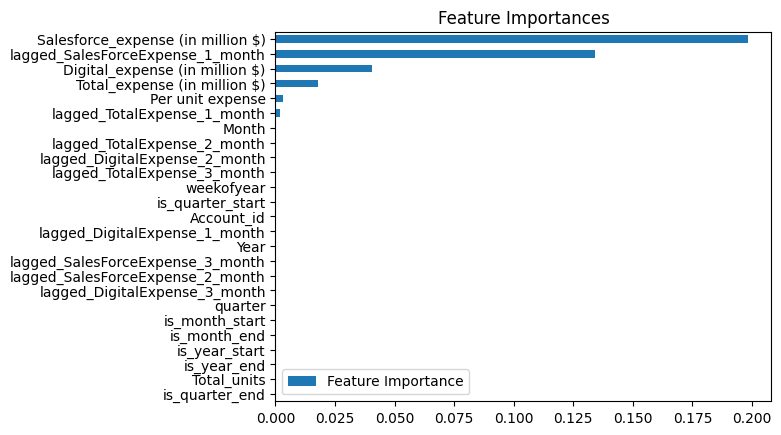

In [ ]:
plt.figure(figsize=(30, 10))
feature_importance.head(25).sort_values('Feature Importance').plot(kind='barh', title='Feature Importances')   #plotting bar graph for feature importances
plt.show()

Expenses Calculation for the future months : Devising Strategy

In [172]:
#getting data of any random store and product
#getting expenses monthwise

sales_y = historical_data.query("Account_id=='00609418' and Product =='Drug_2'")
sales_y['Week'] = pd.to_datetime(sales_y['Week'])
sales_y_feb = sales_y[sales_y['Month']==2]
sales_y_mar = sales_y[sales_y['Month']==3]
sales_y_4 = sales_y[sales_y['Month']==4]
sales_y_5 = sales_y[sales_y['Month']==5]
sales_y_7 = sales_y[sales_y['Month']==7]
sales_y_8 = sales_y[sales_y['Month']==8]
sales_y_9 = sales_y[sales_y['Month']==9]
sales_y_10 = sales_y[sales_y['Month']==10]
sales_y_11= sales_y[sales_y['Month']==11]

<ipython-input-172-b86a9ebdcf80>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sales_y['Week'] = pd.to_datetime(sales_y['Week'])


Analysing for October 2018

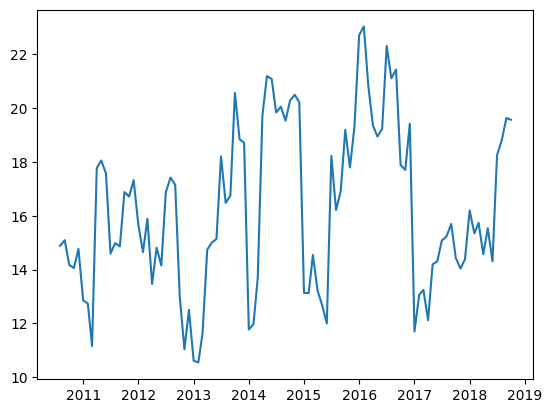

In [173]:
#expenses across all years

plt.plot(sales_y['Week'], sales_y['Total_expense (in million $)'])

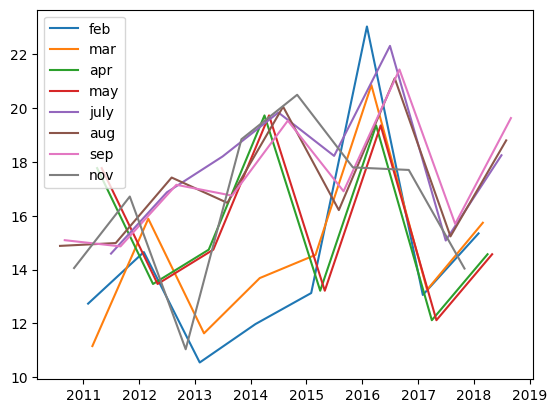

In [174]:
#Graphs for all months from year 2011 to 2018

plt.plot(sales_y_feb['Week'], sales_y_feb['Total_expense (in million $)'],label = 'feb')
plt.plot(sales_y_mar['Week'], sales_y_mar['Total_expense (in million $)'],label = 'mar')
plt.plot(sales_y_4['Week'], sales_y_4['Total_expense (in million $)'],label = 'apr')
plt.plot(sales_y_5['Week'], sales_y_4['Total_expense (in million $)'],label = 'may')
plt.plot(sales_y_7['Week'], sales_y_7['Total_expense (in million $)'],label = 'july')
plt.plot(sales_y_8['Week'], sales_y_8['Total_expense (in million $)'],label = 'aug')
plt.plot(sales_y_9['Week'], sales_y_9['Total_expense (in million $)'],label = 'sep')
#plt.plot(sales_y_10['Week'], sales_y_10['Total_expense (in million $)'],label = 'oct')
plt.plot(sales_y_11['Week'], sales_y_11['Total_expense (in million $)'],label = 'nov')
plt.legend()

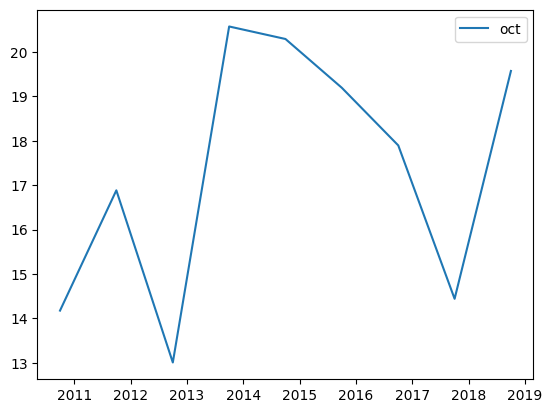

In [176]:
#case 1 : expenses of october 2018 here is effected by average sales of year 2018

plt.plot(sales_y_10['Week'], sales_y_10['Total_expense (in million $)'],label = 'oct')
plt.legend()

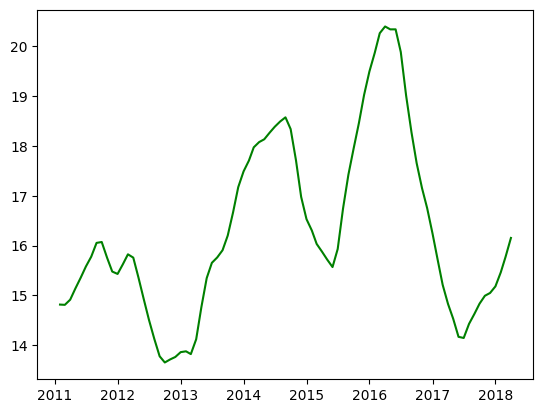

In [177]:
#getting trend for all years

decomposition= seasonal_decompose(sales_y[['Week','Total_expense (in million $)']].set_index('Week'), model = 'additive', period = 12)
estimated_trend = decomposition.trend
plt.plot(estimated_trend, 'g', label='Trend')
plt.show()

# trend is positive across 2018 -> as per all years trend  -> october expenses should increase
#october 2018 expenses increased -> impacted by yearly trend of 2018
# expenses of a future month can be affected both by last month's (as there can be month wise data similarity due to seasonality) or
#yearly data of 2018 (as there can be huge impact of expenses made in the past months of the year)

